# Classification of cell morphological changes with convolutional neural networks
_by Alexander Kensert & Phil Harrison (January 2019)_
## GPU session

## Load packages

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.utils import multi_gpu_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

Using TensorFlow backend.


## Load data

In [2]:
def load_dataset():
    dirname = '/scratch/bbbc021v1_images/'
    x_orig = np.zeros((660, 256, 256, 3), dtype=np.float32)

    for f in range(x_orig.shape[0]):
        img    = Image.open(dirname + 'bbbc021v1_%s.png' % str(f))
        img    = np.array(img)
        x_orig[f] = img

    labels = pd.read_csv('/scratch/bbbc021v1_labels.csv',
                          usecols=["compound", "concentration", "moa"],
                          sep=";")
    y_orig = np.array(labels['moa'])

    return x_orig, y_orig

def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])
    y = np.eye(C)[y]
    y = y.astype('float32')

    return y

x_orig, y_orig = load_dataset()

# Map X to 0-1 range; and convert Y to one hot encoding
x_all = x_orig/255.
y_all = convert_to_one_hot(y_orig, 6)

## ResNet functions

In [3]:
def conv(inputs, num_filters, strides):
    x = Conv2D(num_filters, kernel_size=(3, 3), strides=strides, padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
    return x

def resnet_block(inputs, num_filters, strides):
    x = conv(inputs, num_filters=num_filters, strides=strides)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(x, num_filters=num_filters, strides=1)
    x = BatchNormalization()(x)
    if strides > 1:
        y = conv(inputs, num_filters=num_filters, strides=strides)
        y = BatchNormalization()(y)
    else:
        y = inputs
    z = keras.layers.add([x, y])
    z = Activation('relu')(z)
    return z

## Plotting function

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['acc'])
    ax.plot(model_history.history['val_acc'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_acc'][-1], 3)), 
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.close()

## Speed comparison - running ResNet on a GPU
Here you will see how much more quickly this model runs on a GPU as opposed to on a CPU. This speed improvement is absolutely essential when it comes to comparing different models and exploring the effects of changing the architectures, loss functions, optimizers etc. 

Train on 500 samples, validate on 160 samples
Epoch 1/30
500/500 [==============================] - 7s 15ms/step - loss: 2.2842 - acc: 0.3760 - val_loss: 2.1306 - val_acc: 0.4562
Epoch 2/30
500/500 [==============================] - 2s 3ms/step - loss: 1.7058 - acc: 0.6140 - val_loss: 2.0077 - val_acc: 0.4750
Epoch 3/30
500/500 [==============================] - 2s 3ms/step - loss: 1.4445 - acc: 0.7540 - val_loss: 1.9851 - val_acc: 0.4437
Epoch 4/30
500/500 [==============================] - 2s 3ms/step - loss: 1.2617 - acc: 0.8280 - val_loss: 1.7079 - val_acc: 0.6125
Epoch 5/30
500/500 [==============================] - 1s 3ms/step - loss: 1.1668 - acc: 0.8660 - val_loss: 1.6335 - val_acc: 0.5875
Epoch 6/30
500/500 [==============================] - 2s 3ms/step - loss: 1.0854 - acc: 0.9060 - val_loss: 1.5106 - val_acc: 0.6813
Epoch 7/30
500/500 [==============================] - 2s 3ms/step - loss: 0.9999 - acc: 0.9340 - val_loss: 1.4089 - val_acc: 0.7250
Epoch 8/30
500/500 [=========

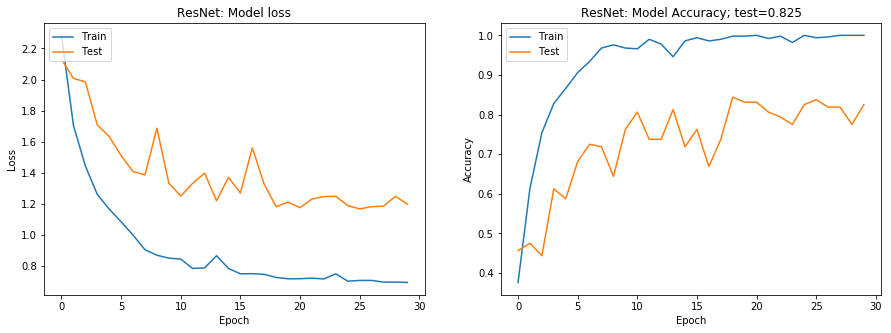

In [5]:
batch_size = 32
epochs = 30
input_shape = (256, 256, 3)
num_classes = 6

indices = np.random.permutation(x_all.shape[0])
train_idx, test_idx = indices[:500], indices[500:]
x_train, x_test = x_all[train_idx, :, :, :], x_all[test_idx, :, :, :]
y_train, y_test = y_all[train_idx, :], y_all[test_idx, :]

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(5, 5), strides=2, padding='same', 
           kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

num_stacks = 3
num_blocks_per_stack = [3, 4, 3]
num_filters_in_stack = [64, 128, 256]

for i in range(num_stacks):
    num_filters = num_filters_in_stack[i]
    for j in range(num_blocks_per_stack[i]):
        if(j == 0):
            strides = 2
        else:
            strides = 1
        x = resnet_block(x, num_filters=num_filters, strides=strides)

x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

plot_history(history, 'ResNet')

## LeNet vs ResNet 

replicate 1


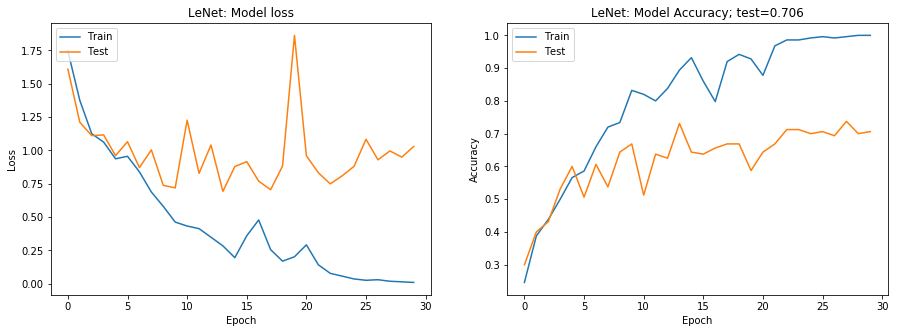

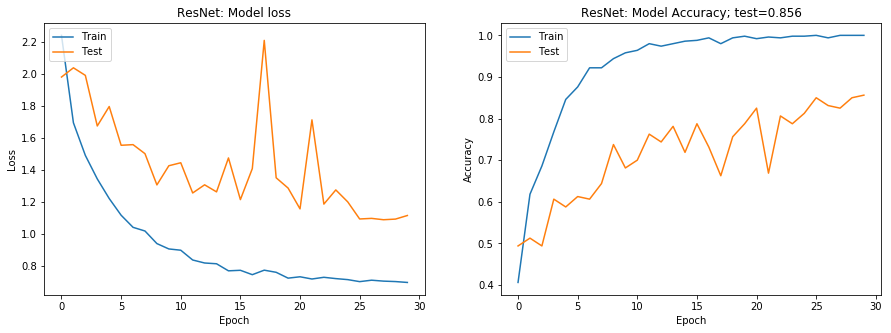

replicate 2


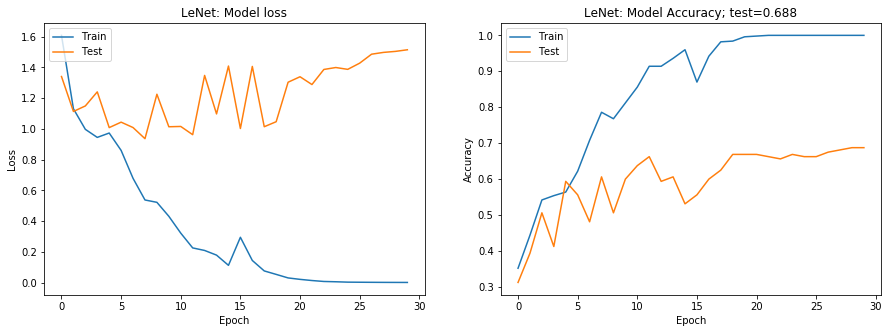

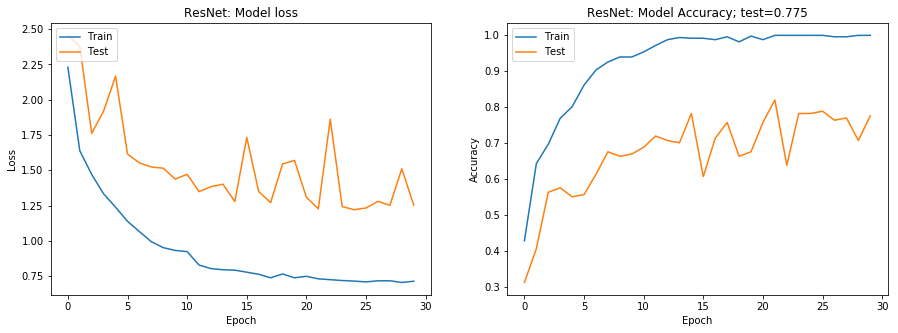

replicate 3


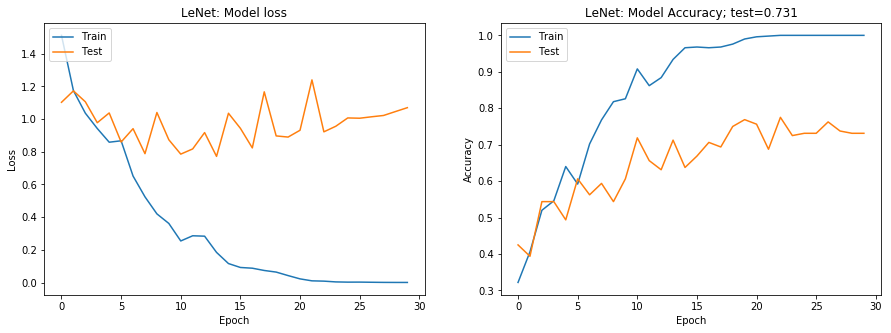

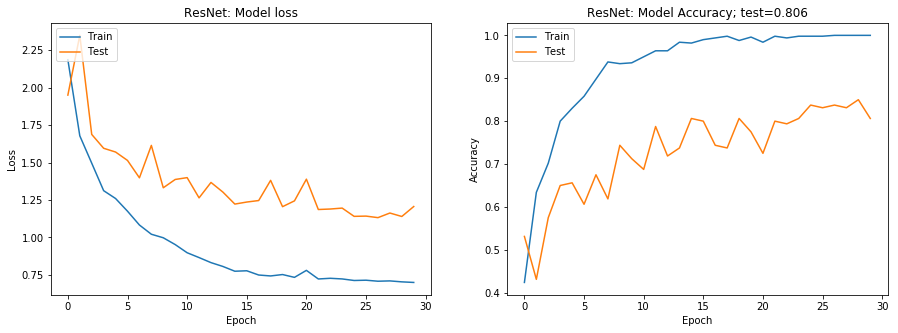

In [6]:
batch_size = 32
epochs = 30
num_rep = 3
input_shape = (256, 256, 3)
num_classes = 6

for ii in range(num_rep):
    print('replicate ' + str(ii+1))
    indices = np.random.permutation(x_all.shape[0])
    train_idx, test_idx = indices[:500], indices[500:]
    x_train, x_test = x_all[train_idx, :, :, :], x_all[test_idx, :, :, :]
    y_train, y_test = y_all[train_idx, :], y_all[test_idx, :]
    
    # LeNet
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5), strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    plot_history(history, 'LeNet')
    
    # ResNet
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(5, 5), strides=2, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    num_stacks = 3
    num_blocks_per_stack = [3, 4, 3]
    num_filters_in_stack = [64, 128, 256]

    for i in range(num_stacks):
        num_filters = num_filters_in_stack[i]
        for j in range(num_blocks_per_stack[i]):
            if(j == 0):
                strides = 2
            else:
                strides = 1
            x = resnet_block(x, num_filters=num_filters, strides=strides)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(),
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    plot_history(history, 'ResNet')
    

## Final exercise
Above you will see a fair amount of stochasticity between different runs of the models. On average though ResNet tends to outperform LeNet. This stochasticity is in part due to the small size of the dataset used for this exercise, but is also a general phenomenon due to the stochastic nature in the train/test split and in the gradient descent algorithm (different runs will find different local minima in the loss surface). 

Using the entire MoA dataset, transfer learning and data augmentation is a preferable way to more fully explore this data (as we did in the paper written by Alexander Kensert - a former student from the same PB-seq masters course you are now on!) [Link](https://journals.sagepub.com/doi/10.1177/2472555218818756) (Kensert et al., 2019).

Now you can experiment with either the LeNet or Resnet model (or both of them). Try making various changes to the models. Can you make the learning more stable? Can you improve the final test accuracy? There is no "correct" answer to this exercise, there are not so many hard and fast rules in deep learning. Expreimentation, imagination and even luck can make developing deep learning models feel more like an art than a science sometimes...